In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from datetime import datetime
import random
from sklearn.cross_validation import train_test_split

color = sns.color_palette()
%matplotlib inline

In [53]:
properties_og = pd.read_csv('properties_2016.csv')
transactions_og = pd.read_csv('train_2016_v2.csv')
train_master = pd.read_csv('train_master.csv', index_col=0)
properties_master = pd.read_csv('imputed.csv')

/Users/Patrick/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [84]:
sample_submission = pd.read_csv('sample_submission.csv')

In [127]:
train_master.dtypes

parcelid                          int64
logerror                        float64
transactiondate                  object
Unnamed: 0                        int64
airconditioningtypeid             int64
basementsqft                      int64
bathroomcnt                     float64
bedroomcnt                        int64
buildingqualitytypeid             int64
calculatedfinishedsquarefeet    float64
fips                              int64
fireplacecnt                      int64
fullbathcnt                       int64
garagecarcnt                      int64
garagetotalsqft                   int64
hashottuborspa                    int64
heatingorsystemtypeid             int64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolsizesum                       int64
pooltypeid2                       int64
pooltypeid7                       int64
propertycountylandusecode         int64
propertylandusetypeid             int64


In [124]:
train_master['latitude']

0        34.280990
1        33.668120
2        34.136312
3        33.755800
4        33.485643
5        33.870089
6        33.899475
7        34.207204
8        33.549600
9        33.612700
10       34.164671
11       34.072220
12       34.189804
13       33.670900
14       33.913333
15       33.676787
16       34.176362
17       33.776400
18       33.770148
19       34.164085
20       33.858594
21       33.754729
22       33.784649
23       33.969828
24       33.773334
25       33.901561
26       34.598115
27       33.486586
28       34.167800
29       33.780400
           ...    
90245    34.167062
90246    33.766300
90247    34.010594
90248    33.719815
90249    34.675820
90250    33.737795
90251    33.898289
90252    33.891465
90253    34.692600
90254    33.892081
90255    34.680299
90256    33.703455
90257    34.151800
90258    34.060800
90259    34.079800
90260    33.897200
90261    34.003038
90262    34.311978
90263    34.155200
90264    34.036709
90265    34.154600
90266    33.

### 1) Preprocessing: Convert 64 bit floats to 32 bit and fix column name types

In [54]:
for c, dtype in zip(train_master.columns, train_master.dtypes):
    if dtype == np.float64:
        train_master[c] = train_master[c].astype(np.float32)

In [55]:
for c in properties_master.columns:
    properties_master[c]=properties_master[c].fillna(-1)
    if properties_master[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(properties_master[c].values))
        properties_master[c] = lbl.transform(list(properties_master[c].values))

In [56]:
train_master = transactions_og.merge(properties_master, how='left', on='parcelid')

## XGBoost

### 1) Initialize train_y, train_xvars, feature names

In [62]:
train_y = train_master['logerror'].values
train_x = train_master.drop(['parcelid', 'logerror', 'transactiondate'], axis = 1)
test_x = properties_master.drop(['parcelid'], axis = 1)
feat_names = train_x.columns.values
mean_y = np.mean(train_y)

In [102]:
random.seed(0)
train_sample = train_master.sample(frac=0.7)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [122]:
y_train.shape

(72220,)

In [63]:
for c in train_x.dtypes[train_x.dtypes == object].index.values:
    train_x[c] = (train_x[c] == True)

In [64]:
print('Shape train: {}\nShape test: {}'.format(train_x.shape, test_x.shape))

Shape train: (90275, 35)
Shape test: (2985217, 35)


### 2) Set parameters

In [88]:
xgb_params = {
    'eta': 0.01,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 0,
    'seed' : 0
}
num_round = 2

### 3) Set train matrix and model

In [67]:
dtrain = xgb.DMatrix(train_x, train_y, feature_names=train_x.columns.values)
dtest = xgb.DMatrix(test_x)

### 4) Cross validation

In [89]:
xgb.cv(xgb_params, dtrain, num_round, nfold = 10,
      metrics = {'error'}, seed = 0,
      callbacks = [xgb.callback.print_evaluation(show_stdv = True)])

[0]	train-error:0.0110586+0.00016817	test-error:0.0118321+0.00124801
[1]	train-error:0.0108414+0.000234347	test-error:0.0118759+0.0012229


,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.011832,0.001248,0.011059,0.000168
1,0.011876,0.001223,0.010841,0.000234


In [91]:
res = xgb.cv(xgb_params, dtrain, num_boost_round = num_boost_rounds, nfold = 10,
            metrics = {'error'}, seed = 0,
            callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                        xgb.callback.early_stop(3)])

[0]	train-error:0.0110586	test-error:0.0118321
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 3 rounds.
[1]	train-error:0.0108414	test-error:0.0118759
[2]	train-error:0.0108005	test-error:0.0118065
[3]	train-error:0.0108028	test-error:0.0116591
[4]	train-error:0.01074	test-error:0.0117054
[5]	train-error:0.0107355	test-error:0.0116003
[6]	train-error:0.0107307	test-error:0.0115608
[7]	train-error:0.0107486	test-error:0.0115673
[8]	train-error:0.010733	test-error:0.0115647
[9]	train-error:0.0107349	test-error:0.0115265
[10]	train-error:0.0107502	test-error:0.0115179
[11]	train-error:0.0107814	test-error:0.0115097
[12]	train-error:0.0107448	test-error:0.0115266
[13]	train-error:0.0107389	test-error:0.0114965
[14]	train-error:0.0107449	test-error:0.0115178
[15]	train-error:0.0107395	test-error:0.0115196
[16]	train-error:0.0107637	test-error:0.0114992
Stopping. Best iteration:
[13]	train-error:0.0107389+

### 4) Set number of boosting rounds

In [90]:
num_boost_rounds = 150

### 5) Train model

In [68]:
model = xgb.train(dict(xgb_params), dtrain, num_boost_round=num_boost_rounds)

In [ ]:
modelfit(model)

### 6) Predict test values

In [69]:
xgb_predict = model.predict(dtest)

### 7) Set up writing predictions to csv

In [77]:
output = pd.DataFrame({'ParcelId': properties_master['parcelid'],
                      '201610': xgb_predict, '201611': xgb_predict, '201612': xgb_predict,
                      '201710': xgb_predict, '201711': xgb_predict, '201712': xgb_predict})
cols = output.columns.tolist()
cols = cols[-1:] + cols[:-1]
output = output[cols]

In [80]:
output.to_csv('zillow_pillow_sub1.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

In [83]:
output.shape

(2985217, 7)

In [86]:
sample_submission.shape

(2985217, 7)

### 4) Visualize Feature Importance

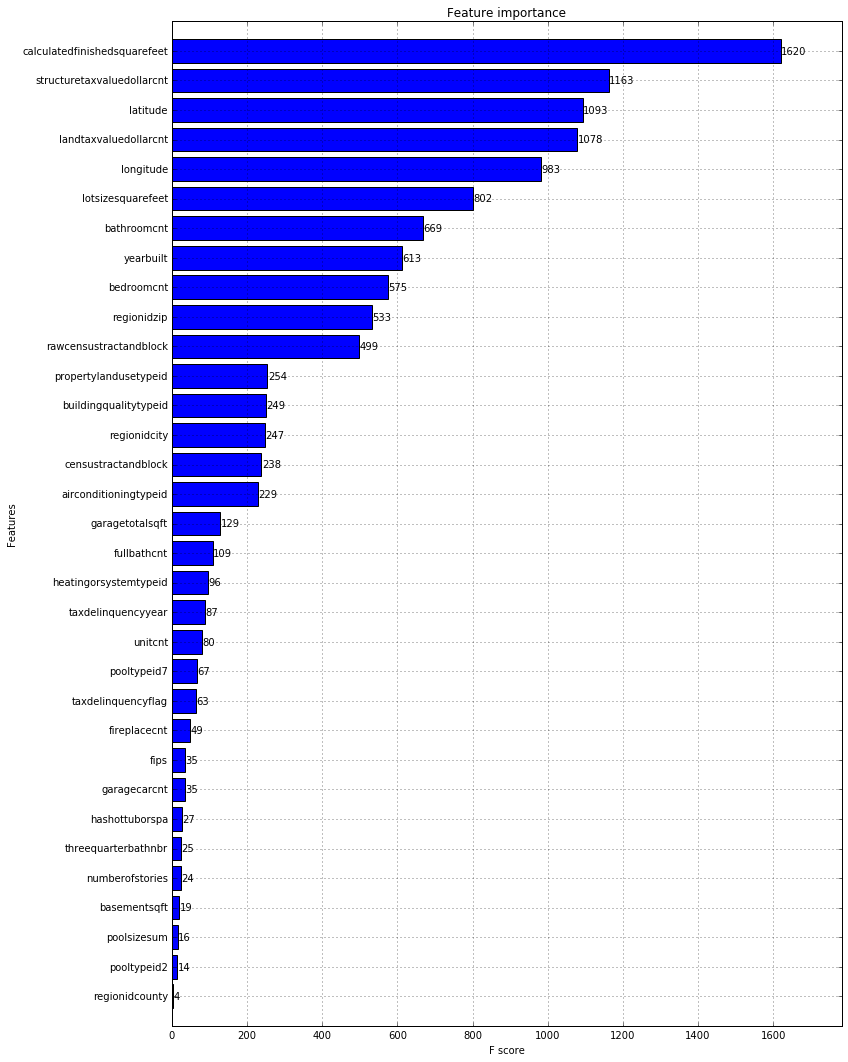

In [47]:
#imputed values
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

In [94]:
xgb.plot.deepness(model = model)

AttributeError: module 'xgboost' has no attribute 'plot'